# MIDS Semester 1 Visualization (Spring '22)

In [1]:
# notebook setup
## import external libraries
from dotenv import load_dotenv
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud
from datetime import datetime
import os
import sys

## get file paths (defined in .env of root directory)
load_dotenv()

## custom modules
sys.path.insert(1, os.environ.get("UTILS"))  # add personal utils from my technical wiki to search path
from obsidian import *  # import my obsidian utility functions

## notebooks parameters
SEMESTER = 'One'
CLASSES = 'W200 and W201'

## show versions
print("Python version:", sys.version)
print("Pandas version:", pd.__version__)
print("Numpy version:", np.__version__)
print("Matplotlib version:", matplotlib.__version__)
print("Wordcloud version:", wordcloud.__version__)

%matplotlib inline

Python version: 3.9.12 (main, Apr  5 2022, 01:53:17) 
[Clang 12.0.0 ]
Pandas version: 1.4.1
Numpy version: 1.20.3
Matplotlib version: 3.5.1
Wordcloud version: 1.8.1


## Data Ingestion

In [7]:
columns = ['t-MIDS', 'Date']
rename = {'t-MIDS': 'Time'}
types = {'t-MIDS': np.float64}
df = pd.read_csv("semester1.csv",  parse_dates=['Date'], usecols=columns, dtype=types).fillna(0).rename(columns=rename)

## Time Series

In [8]:
weeks = df.set_index('Date').resample('W').sum().iloc[1:]  # upsample daily to weekly

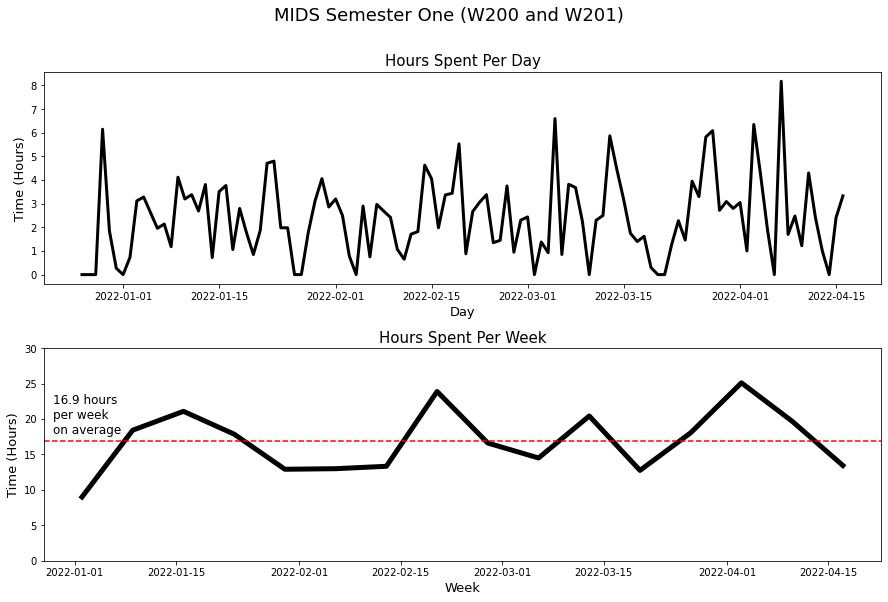

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(15, 9))

ax1 = ax[0]
ax2 = ax[1]

# plots
ax1.plot(df.Date, df.Time, color='black', linewidth=3) # adds histogram to the Axes subplot in position 1
ax2.plot(weeks.index, weeks.Time, color='black', linewidth=5)
plt.axhline(weeks.Time.mean(), linestyle='--', color='r')  # average time spent per week
ax2.text(datetime(2021,12,29), 18, f"{round(weeks.Time.mean(), 1)} hours\nper week\non average", fontsize=12)

# configure axes and title
ax1.set_xlabel('Day', fontsize=13)
ax1.set_ylabel('Time (Hours)', fontsize=13)
ax1.set_title("Hours Spent Per Day", fontsize=15)
ax2.set_xlabel('Week', fontsize=13)
ax2.set_ylabel('Time (Hours)', fontsize=13)
ax2.set_title("Hours Spent Per Week", fontsize=15)
fig.suptitle(f'MIDS Semester {SEMESTER} ({CLASSES})', fontsize=18) # Figure title
ax2.set_ylim(0, 30)

fig.subplots_adjust(hspace=.3)

plt.savefig(f"visuals/MIDS Semester {SEMESTER} Time Series.png")
plt.show()

## Notes Word Cloud

Define the function to extract content from MIDS notes in PKM system

In [2]:
def get_mids_text(file):
    with open(file, 'r') as f:
        tags = get_pkm_tags(file)
        if tags is None:
            f.close()
            return ''
        elif "mids" in tags:
            words = ''
            metadata = True
            line = f.readline()
            while metadata:
                # skip over metadata
                line = f.readline()
                if line[:3] == '---':
                    # reached end of metadata
                    metadata = False
            while '## Anki Flashcards' not in line and line != '':
                # print(line)
                # extract content between metadata and Anki section
                words += line
                line = f.readline()
        else:
            f.close()
            return ''
    
    # postprocessing
    ## remove symbols, remove stopwords (not included in wordcloud package)
    words = words.replace('\n', ' ').replace('\t', ' ').replace('[[', ' ').replace(']]', ' ').replace('|', ' ')
    stop_words = [" will ", " one ", "pg", " way ", "because", "wants", "want", " uses ", " use ", " using ", "student", " good ", " s ", " make "]
    for stop_word in stop_words:
        words = words.replace(stop_word, '')
    
    return words

In [3]:
pkm_path = os.environ.get("PKM")
text_list = apply_to_pkm_vault(get_mids_text, pkm_path)
mids_text_list = [string for string in text_list if string != '']
text = '; '.join(text_list)

In [4]:
print("Number of words typed:", len(text))

Number of words typed: 227378


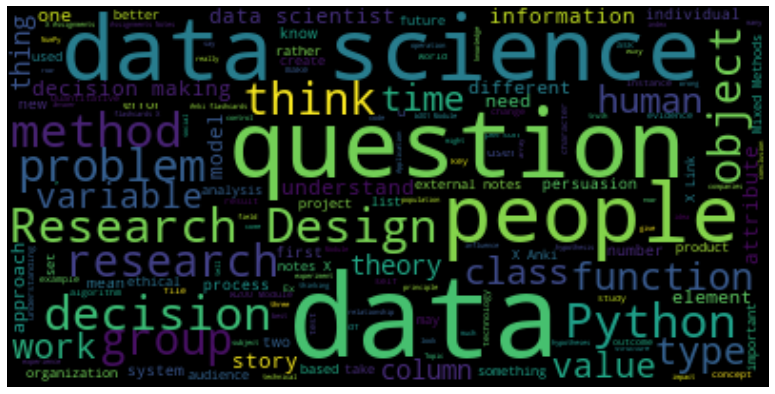

In [6]:
wordcloud = WordCloud().generate(text)

wordcloud = WordCloud(max_font_size=60).generate(text)
plt.figure(figsize=(18,7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(f"visuals/MIDS Semester {SEMESTER} Word Cloud.png")
plt.show()